In [7]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import prune

import numpy as np
import matplotlib.pyplot as plt
import copy

plt.rcParams['font.family'] = 'Bookman Old Style'

def phase_vector(x):
    """Takes a vector x and returns a vector of phases of each element"""
    Ax = np.abs(x)
    return np.conj(x)/Ax

def model_expected_output(y, phase, num_memory_levels):
    """Take in data, phase normalised it, and trim. Return as IQ seperately"""
    y_denorm = y*phase
    y_denorm_trim = y_denorm[num_memory_levels:]
    return np.array([np.real(y_denorm_trim), np.imag(y_denorm_trim)]).T

def build_xfc(x, num_memory_levels):
    """
    Replicates the MATLAB build_xfc() function.
    """
    num_points = len(x)
    phase = phase_vector(x)
    I = np.real(x)
    Q = np.imag(x)

    # Phase-normalized data
    phase_norm_data = np.zeros((num_points, num_memory_levels), dtype=complex)
    for n in range(num_memory_levels, num_points):
        for m in range(num_memory_levels):
            phase_norm_data[n, m] = x[n - m - 1] * phase[n]

    # Ax magnitude feature
    Ax = np.sqrt(I**2 + Q**2)

    # Build A feature matrix (Ax memory taps)
    A_feats = np.zeros((num_points, num_memory_levels))
    for n in range(num_memory_levels, num_points):
        for m in range(num_memory_levels):
            A_feats[n, m] = Ax[n - m]

    # Trim first num_memory_levels samples (as in MATLAB)
    phase_norm_data = phase_norm_data[num_memory_levels:, :]
    A_feats = A_feats[num_memory_levels:, :]
    A3_feats = A_feats ** 3

    # Combine real and imaginary phase-normalized parts with A-features
    xfc = np.hstack([
        np.real(phase_norm_data),
        np.imag(phase_norm_data),
        A_feats,
        A3_feats
    ]).astype(np.float32)

    return xfc

def build_x_matrix(x, num_mem_levels, num_nl_orders):
    """Build Matrix X for find Volterra Model"""
    num_points = len(x)
    X = np.zeros((num_points, num_mem_levels * num_nl_orders), dtype=np.complex128)
    
    for n in range(num_mem_levels - 1, num_points):
        col = 0
        for i in range(num_mem_levels):
            xi = x[n - i]
            for j in range(num_nl_orders):
                X[n, col] = (abs(xi) ** ((j) * 2)) * xi
                col += 1

    return X

def build_y(u, A, num_mem_levels, num_nl_orders):
    """Builds y, the output of the volterra Model. Trims Output"""
    num_points = len(u)
    y = np.zeros((num_points, 1), dtype=np.complex128)
    for n in range(num_mem_levels - 1, num_points):
        col = 0 
        for i in range(num_mem_levels):
            ui = u[n-i]
            for j in range(num_nl_orders):
                y[n]= y[n] + A[col]*(abs(ui)**(j*2)*ui)
                col += 1
    y = y[num_memory_levels:]
    return y
        

def volterra(x, y, num_memory_levels, num_nl_orders):
    """Build component matrix A"""
    X = build_x_matrix(x, num_memory_levels, num_nl_orders)
    
    X_trim = X[num_memory_levels:, :]
    y_trim = y[num_memory_levels:]
    return np.linalg.pinv(X_trim.conj().T @ X_trim) @ (X_trim.conj().T @ y_trim);


# Load Matlab Data
data = scipy.io.loadmat("PA_IO.mat")
x = data["x"].squeeze()
y = data["y"].squeeze()


num_training_points = 5000
num_memory_levels = 3 # If there are 0 memory taps, this is 1

idx_training = range(0, num_training_points -1)

model_training_input = y[idx_training]
model_training_output = x[idx_training]

# Assign some data for just validation
num_validation_points = 5000
validation_end_index = num_training_points + num_validation_points

model_valid_input = y[num_training_points: validation_end_index]
model_valid_output = x[num_training_points: validation_end_index]

training_phase = phase_vector(model_training_input)
valid_phase = phase_vector(model_valid_input)

# Inverse Model 
model_training_expected_output = model_expected_output(model_training_output, training_phase, num_memory_levels) #Find what the model should output
model_xfc = build_xfc(model_training_input, num_memory_levels) # Build xfc from model input

valid_xfc = build_xfc(model_valid_input, num_memory_levels)
model_valid_expected_output = model_expected_output(model_valid_output, valid_phase, num_memory_levels)


x_data = x[validation_end_index:]
y_data = y[validation_end_index:]



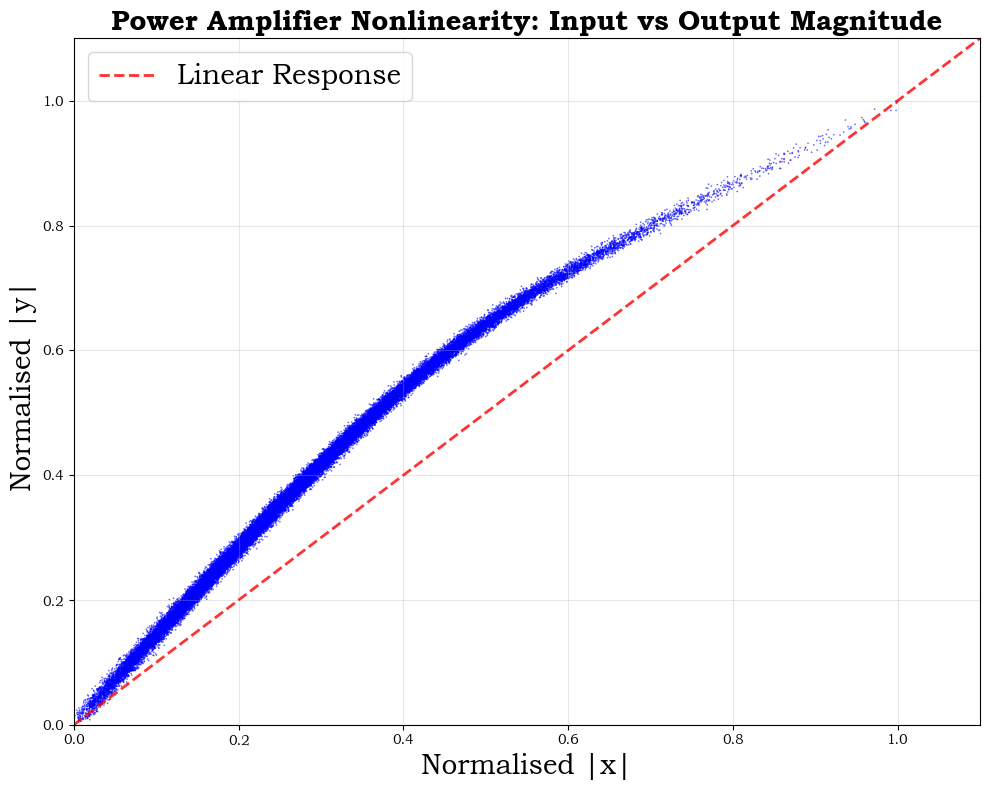

In [23]:
# Plot input vs output to show non-linearity
plt.figure(figsize=(10, 8))
plt.scatter(np.abs(x_data), np.abs(y_data), s=1.5, alpha=0.6, c='blue', edgecolors='none')
plt.plot([0, 1.1], [0, 1.1], 'r--', linewidth=2, alpha=0.8, label='Linear Response')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xlabel('Normalised |x|', fontsize=20)
plt.ylabel('Normalised |y| ', fontsize=20)
plt.title('Power Amplifier Nonlinearity: Input vs Output Magnitude', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

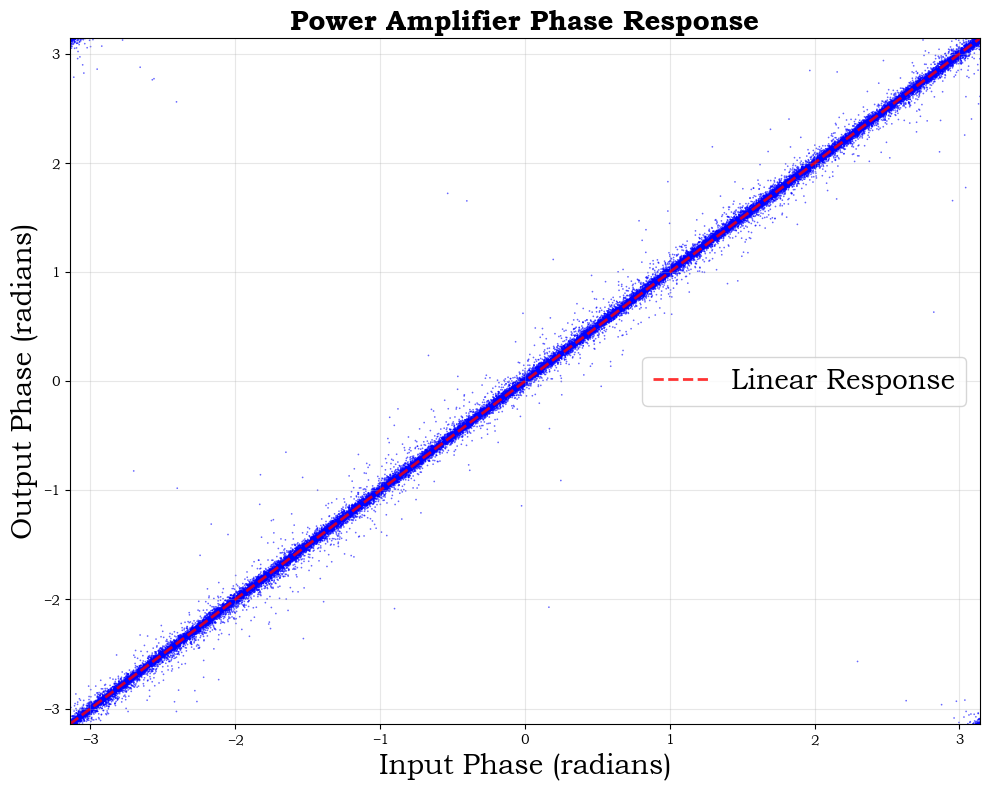

In [24]:
# Plot the phase
plt.figure(figsize=(10, 8))
plt.scatter(np.angle(x_data), np.angle(y_data), s=1.5, alpha=0.6, c='blue', edgecolors='none')
plt.plot([-np.pi, np.pi], [-np.pi, np.pi], 'r--', linewidth=2, alpha=0.8, label='Linear Response')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('Input Phase (radians)', fontsize=20)
plt.ylabel('Output Phase (radians)', fontsize=20)
plt.title('Power Amplifier Phase Response', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Get Volterra Model of PA
num_memory_levels = 3
num_nl_orders = 5
A = volterra(model_training_output, model_training_input, num_memory_levels, num_nl_orders)
print(A)


[ 1.54996424+0.231149j   -0.42706522-0.31633449j -1.50564817+1.90788486j
  2.98722013-3.08261378j -1.59404636+1.66147922j -0.22545683-0.44929453j
  0.03761166-0.04908903j  0.03710063+0.33581504j -0.04496924-0.76784164j
  0.01303703+0.53153523j  0.12826453+0.26006374j -0.03763837-0.0102274j
  0.04533442+0.10082778j -0.04063175-0.27397055j  0.0058124 +0.22612464j]


In [10]:
# Train NN on backprop PA for inv model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
class PNTDNN(nn.Module):
    def __init__(self, input_size, hidden_size=12, output_size=2):
        super(PNTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
        

# Convert to tensors:
X = torch.tensor(model_xfc, dtype=torch.float32)
Y = torch.tensor(model_training_expected_output, dtype=torch.float32)

X_valid = torch.tensor(valid_xfc, dtype=torch.float32)
Y_valid = torch.tensor(model_valid_expected_output, dtype=torch.float32)

training_dataset = TensorDataset(X, Y)
valid_dataset = TensorDataset(X_valid, Y_valid)
training_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)

input_size = X.shape[1]
model = PNTDNN(input_size)

criterion = nn.MSELoss() # Measure MSE, i.e distance between predicted and actual. 
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# Train Inv Model
num_epochs = 400
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_valid_loss = 0
    for xb, yb in training_loader: # Iterate through 
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() 
    train_loss = running_train_loss/len(training_loader.dataset)
        
    for xb, yb in valid_loader: # Iterate through Validation
        preds = model(xb)
        loss = criterion(preds, yb)
        running_valid_loss += loss.item() 
    valid_loss = running_valid_loss/len(valid_loader.dataset)
    
    
    
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}  Loss={train_loss:.4e}")
        



Using cpu device
Epoch  10/400  Loss=2.7055e-06
Epoch  20/400  Loss=4.9873e-07
Epoch  30/400  Loss=3.4175e-07
Epoch  40/400  Loss=2.5745e-07
Epoch  50/400  Loss=2.0011e-07
Epoch  60/400  Loss=1.6861e-07
Epoch  70/400  Loss=1.4627e-07
Epoch  80/400  Loss=1.3234e-07
Epoch  90/400  Loss=1.2087e-07
Epoch 100/400  Loss=1.1294e-07
Epoch 110/400  Loss=1.0682e-07
Epoch 120/400  Loss=9.8390e-08
Epoch 130/400  Loss=9.2801e-08
Epoch 140/400  Loss=9.0171e-08
Epoch 150/400  Loss=8.2869e-08
Epoch 160/400  Loss=8.3532e-08
Epoch 170/400  Loss=7.7379e-08
Epoch 180/400  Loss=6.9179e-08
Epoch 190/400  Loss=6.2957e-08
Epoch 200/400  Loss=5.9191e-08
Epoch 210/400  Loss=5.9241e-08
Epoch 220/400  Loss=5.5525e-08
Epoch 230/400  Loss=5.3665e-08
Epoch 240/400  Loss=5.2062e-08
Epoch 250/400  Loss=5.1704e-08
Epoch 260/400  Loss=5.0116e-08
Epoch 270/400  Loss=4.8903e-08
Epoch 280/400  Loss=4.9381e-08
Epoch 290/400  Loss=4.7637e-08
Epoch 300/400  Loss=4.8285e-08
Epoch 310/400  Loss=4.6902e-08
Epoch 320/400  Loss=4.

In [11]:
print(input_size)

12


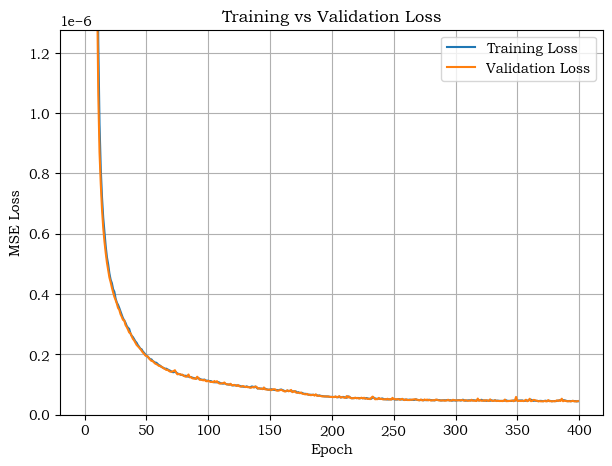

In [12]:
# Plot losses
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.ylim(0, np.mean(valid_losses)*2)

plt.show()

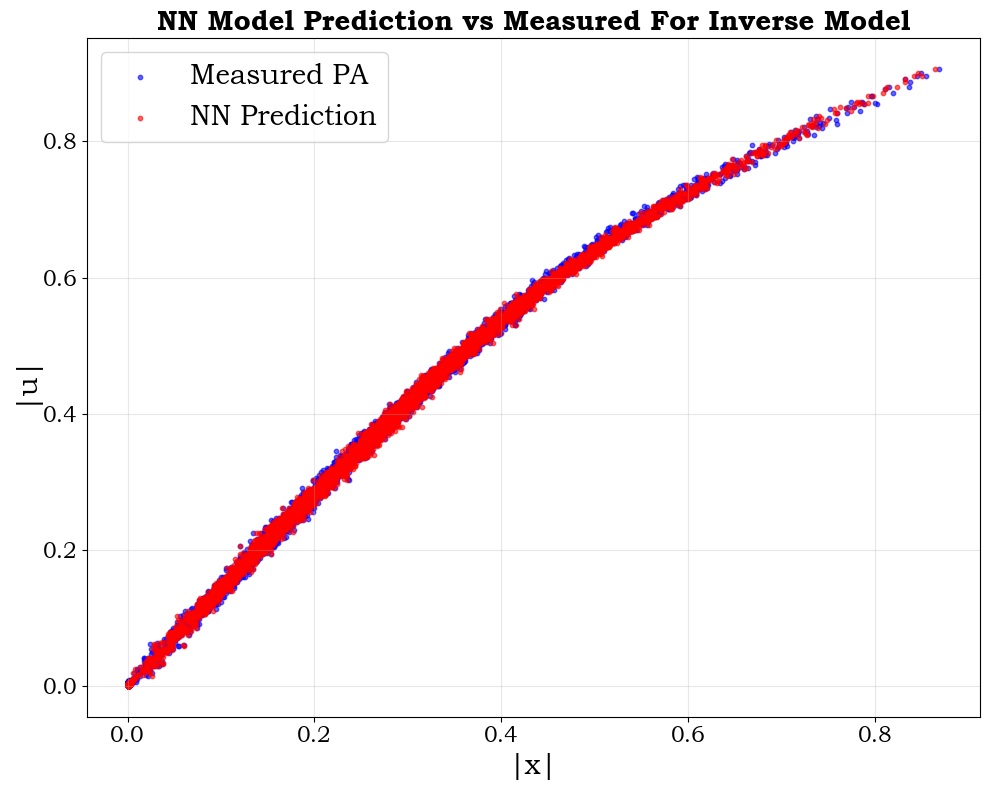

In [13]:
# Use trained model
def plot_inv_model(model):
    model.eval()
    Y_pred = model(X).detach().numpy()
    y_pred_complex = Y_pred[:, 0] + 1j * Y_pred[:, 1]

    phase = phase_vector(model_training_input)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(np.abs(model_training_output[num_memory_levels:]), np.abs(model_training_input[num_memory_levels:]), 
                label='Measured PA', s=10, alpha=0.6, c='blue')
    plt.scatter(np.abs(y_pred_complex*np.conj(phase[num_memory_levels:])), np.abs(model_training_input[num_memory_levels:]), 
                label='NN Prediction', s=10, alpha=0.6, c='red')
    plt.xlabel('|x|', fontsize=20)
    plt.ylabel('|u|', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('NN Model Prediction vs Measured For Inverse Model', fontsize=20, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.show()

plot_inv_model(model)

In [14]:
def prune_model(weights_per_epoch, num_rounds=6):
    pruned_model = copy.deepcopy(model)
    data_losses = []
    valid_losses = []
    for i in range(num_rounds):
        prune.l1_unstructured(
        pruned_model.fc1, "weight", amount=weights_per_epoch
    )
        #prune.remove(pruned_model.fc1, "weight")  # make pruning permanent
        
        
        optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, min_lr=1e-6)

        num_epochs = 200
        for epoch in range(num_epochs):
            pruned_model.train()
            running_valid_loss = 0
            running_data_loss = 0
            for xb, yb in training_loader:
                optimizer.zero_grad()
                preds = pruned_model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_data_loss += loss.item()
            
            data_loss = running_data_loss/len(training_loader.dataset)
            data_losses.append(data_loss)
            
            for xb, yb in valid_loader: # Iterate through Validation
                preds = pruned_model(xb)
                loss = criterion(preds, yb)
                running_valid_loss += loss.item() 
                
            valid_loss = running_valid_loss/len(valid_loader.dataset)
            valid_losses.append(valid_loss)
            
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1:3d}/{num_epochs}  Loss={data_loss:.4e}")
                
        # print sparsity
        weight = pruned_model.fc1.weight.detach().cpu().numpy()
        sparsity = np.mean(weight == 0) * 100 # Check what percent of weights are 0
        print(f"Layer sparsity: {sparsity:.2f}%")
    
    results = {
        "models": pruned_model,
        "data_losses": data_losses,
        "valid_losses": valid_losses
    }
        
    return results


In [15]:
def inv_pa(model):
    """Return the Output of the inverse model (trimmed)"""

    phase_data = phase_vector(x_data[num_memory_levels:])
    xfc_data = build_xfc(x_data, num_memory_levels)
    y_data_trim = y_data[num_memory_levels:]

    # Convert to tensors:
    X_data = torch.tensor(xfc_data, dtype=torch.float32)

    model.eval()
    U_pred = model(X_data).detach().numpy()
    U_pred_complex = (U_pred[:, 0] + 1j * U_pred[:, 1])*np.conj(phase_data) # Phase Denormalised
    return U_pred_complex
    

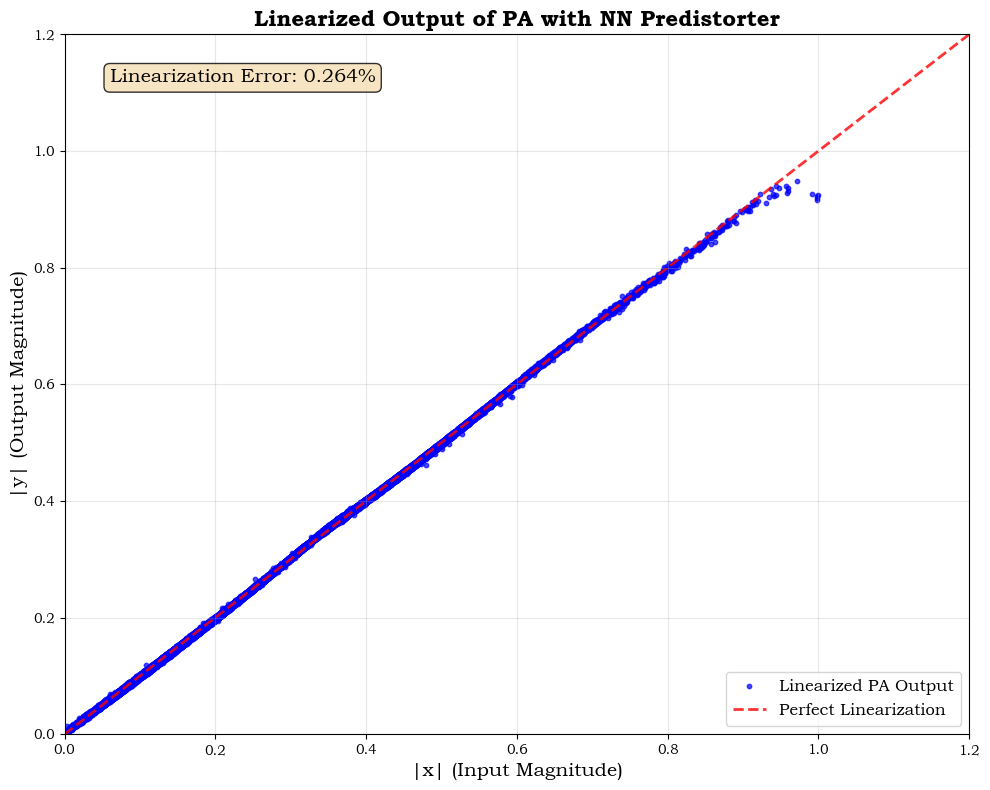

In [16]:
# Plot linearised output of PA with NN predistorter
# Run through inverse model
U_pred_complex = inv_pa(model)

y_lin = build_y(U_pred_complex, A, num_memory_levels, num_nl_orders)
error = 0

for j in range(len(y_lin)):
    error += np.abs(y_lin[j] - x_data[j + 2*num_memory_levels])
error = error/len(y_lin)

plt.figure(figsize=(10, 8))
plt.scatter(abs(x_data[2*num_memory_levels:]), abs(y_lin), s=10, alpha=0.7, c='blue', label='Linearized PA Output')
plt.plot([0, 1.2], [0, 1.2], 'r--', linewidth=2, alpha=0.8, label='Perfect Linearization')
plt.xlim(0, 1.2)
plt.ylim(0, 1.2)
plt.xlabel("|x| (Input Magnitude)", fontsize=14)
plt.ylabel("|y| (Output Magnitude)", fontsize=14)
plt.title("Linearized Output of PA with NN Predistorter", fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add error text box
textstr = f"Linearization Error: {100*error[0]:.3f}%"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [17]:
# Train a bunch of models, plot losses

weight_cut_values =[0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
results = []


valid_losses_matrix = np.zeros(len(weight_cut_values))
data_losses_matrix = np.zeros(len(weight_cut_values))

for i in range(len(weight_cut_values)):
    results.append(prune_model(weight_cut_values[i]))
    

Epoch  10/200  Loss=4.4603e-08
Epoch  20/200  Loss=4.4786e-08
Epoch  30/200  Loss=4.7026e-08
Epoch  40/200  Loss=4.4858e-08
Epoch  50/200  Loss=4.5706e-08
Epoch  60/200  Loss=4.6597e-08
Epoch  70/200  Loss=4.4622e-08
Epoch  80/200  Loss=4.4847e-08
Epoch  90/200  Loss=4.4963e-08
Epoch 100/200  Loss=4.6327e-08
Epoch 110/200  Loss=4.5030e-08
Epoch 120/200  Loss=4.3847e-08
Epoch 130/200  Loss=4.4368e-08
Epoch 140/200  Loss=4.7350e-08
Epoch 150/200  Loss=4.5658e-08
Epoch 160/200  Loss=4.3791e-08
Epoch 170/200  Loss=4.4144e-08
Epoch 180/200  Loss=4.4470e-08
Epoch 190/200  Loss=4.3889e-08
Epoch 200/200  Loss=4.7171e-08
Layer sparsity: 9.72%
Epoch  10/200  Loss=4.4306e-08
Epoch  20/200  Loss=4.4089e-08
Epoch  30/200  Loss=4.5004e-08
Epoch  40/200  Loss=4.3974e-08
Epoch  50/200  Loss=4.5657e-08
Epoch  60/200  Loss=4.4775e-08
Epoch  70/200  Loss=4.3244e-08
Epoch  80/200  Loss=4.4038e-08
Epoch  90/200  Loss=4.5592e-08
Epoch 100/200  Loss=4.4009e-08
Epoch 110/200  Loss=4.4478e-08
Epoch 120/200  Lo

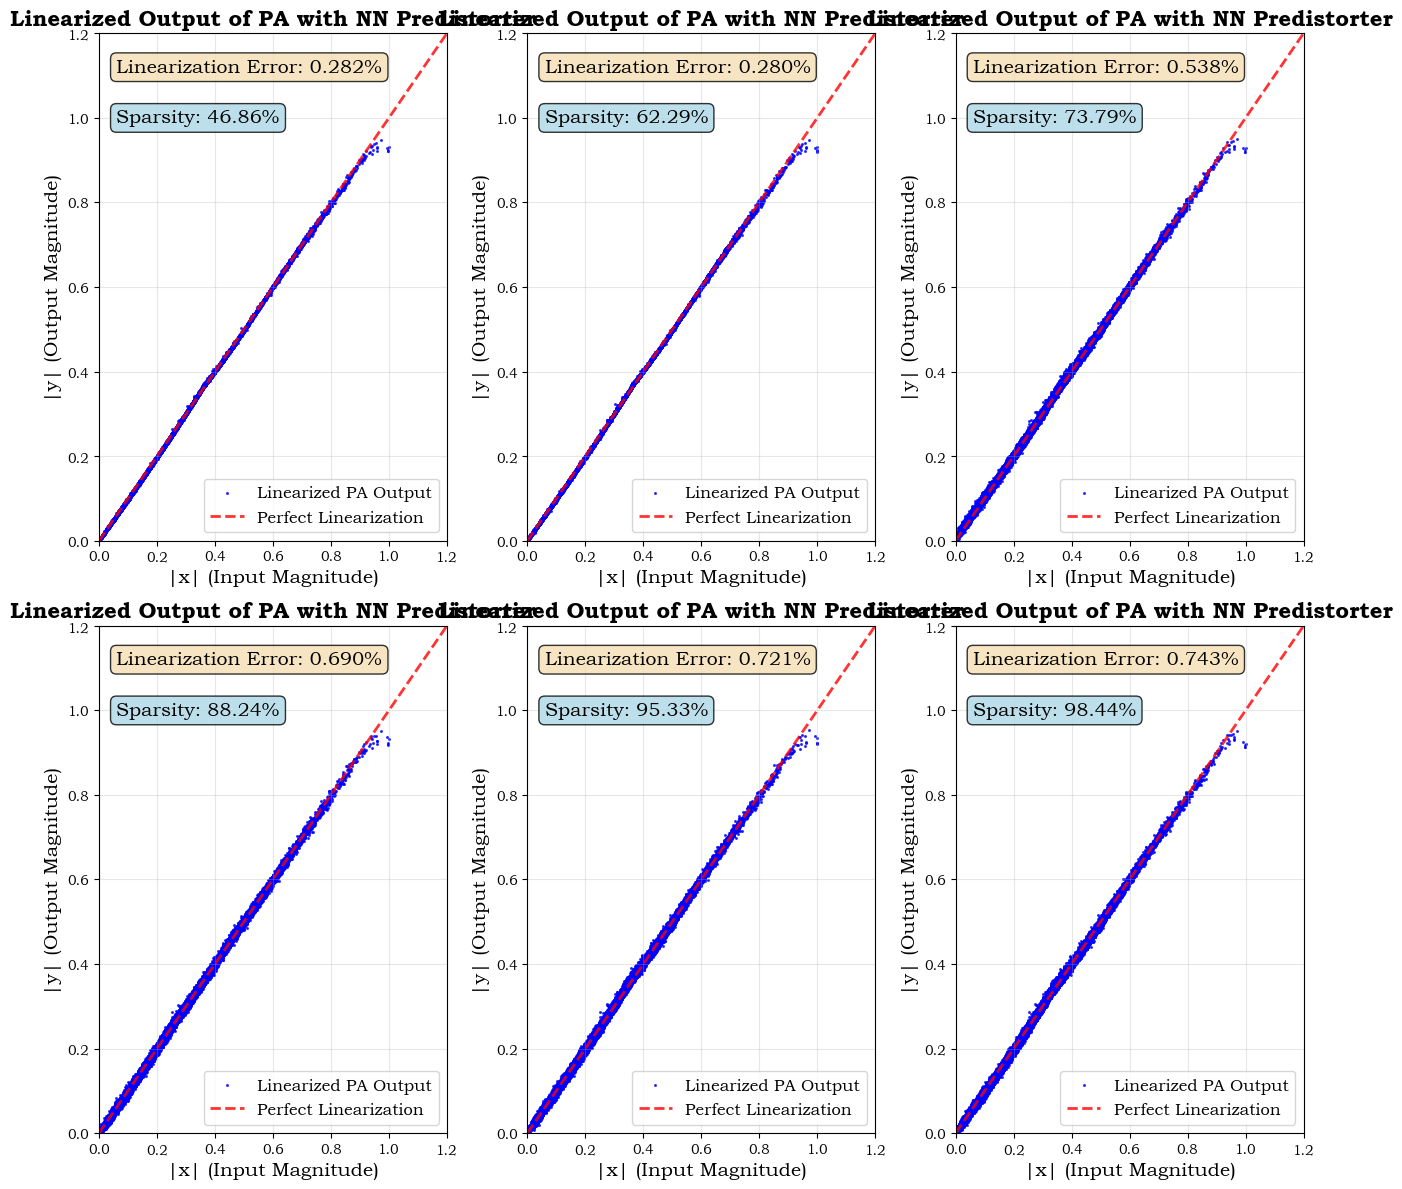

In [18]:
# Plot input vs output to show non-linearity for each pruned model
pruned_models = [results[i]["models"] for i in range(len(weight_cut_values))]
errors = []  # Initialize errors list

fig, axs = plt.subplots(2,3, figsize=(13, 12))
axs = axs.ravel() #Flatten out array

for i in range(len(weight_cut_values)):
    U_pred_complex = inv_pa(pruned_models[i])

    y_lin = build_y(U_pred_complex, A, num_memory_levels, num_nl_orders)
    error = 0

    for j in range(len(y_lin)):
        error += np.abs(y_lin[j] - x_data[j + 2*num_memory_levels])
    error = error/len(y_lin)
    
    errors.append(error)  # Store the error for this model

    axs[i].scatter(abs(x_data[2*num_memory_levels:]), abs(y_lin), s=1.5, alpha=0.7, c='blue', label='Linearized PA Output')
    axs[i].plot([0, 1.2], [0, 1.2], 'r--', linewidth=2, alpha=0.8, label='Perfect Linearization')
    axs[i].set_xlim(0, 1.2)
    axs[i].set_ylim(0, 1.2)
    axs[i].set_xlabel("|x| (Input Magnitude)", fontsize=14)
    axs[i].set_ylabel("|y| (Output Magnitude)", fontsize=14)
    axs[i].set_title("Linearized Output of PA with NN Predistorter", fontsize=16, fontweight='bold')
    axs[i].grid(True, alpha=0.3)
    axs[i].legend(fontsize=12)
    # Add error text box
    textstr = f"Linearization Error: {100*error[0]:.3f}%"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axs[i].text(0.05, 0.95, textstr, transform=axs[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    # Add sparsity text box
    sparisity = 1- (1-weight_cut_values[i])**6 
    textstr2 = f"Sparsity: {sparisity*100:.2f}%"
    props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    axs[i].text(0.05, 0.85, textstr2, transform=axs[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props2)

plt.tight_layout()
plt.show()

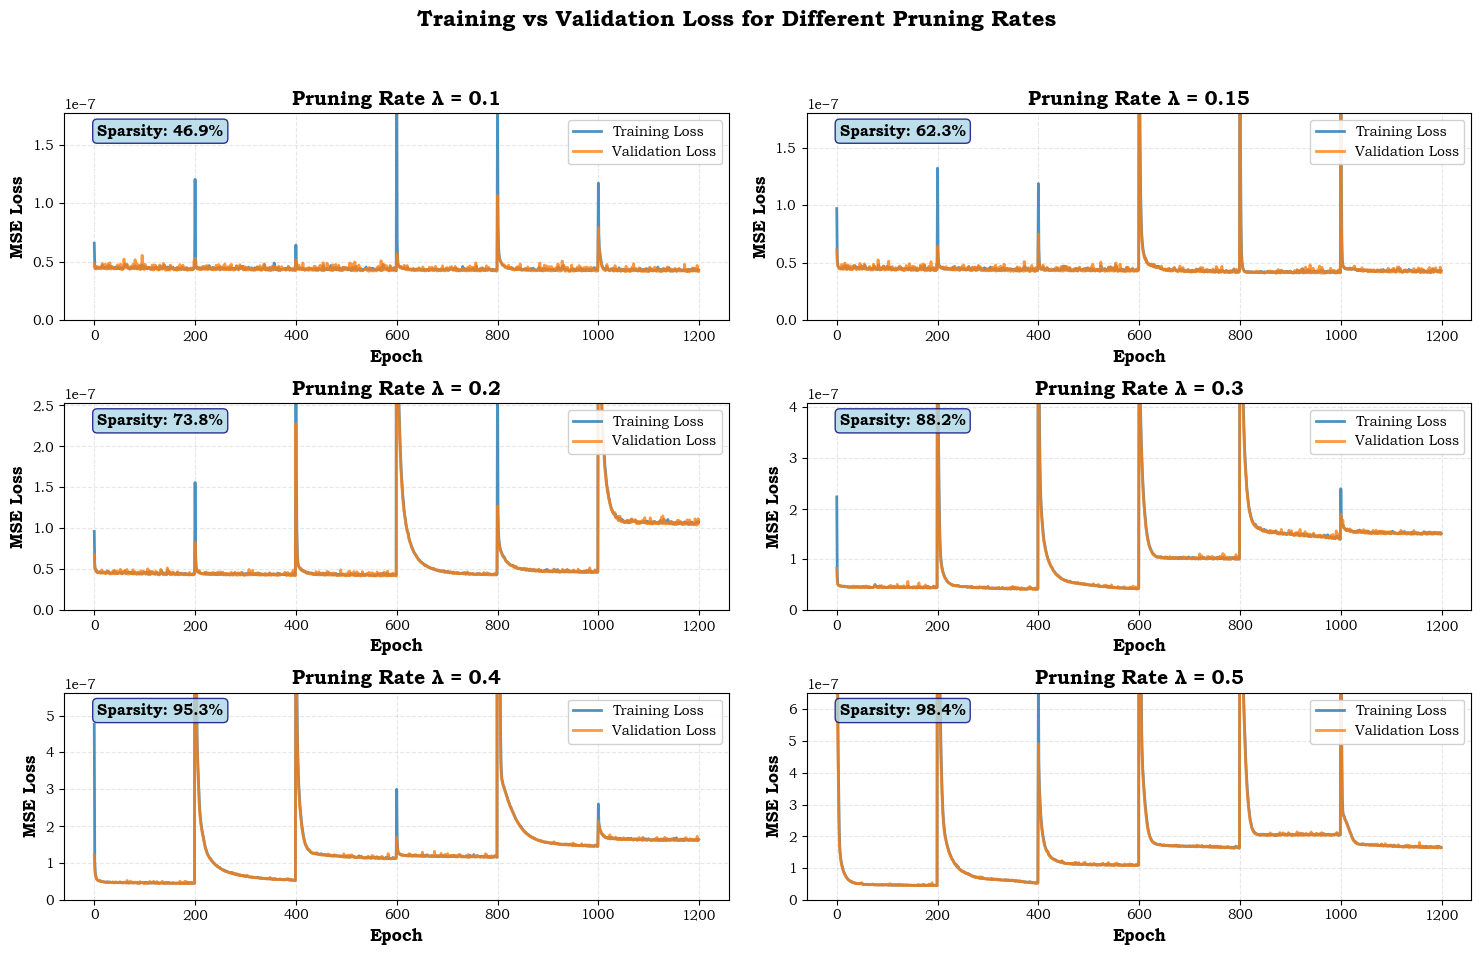

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()

for i in range(len(weight_cut_values)):
    result = results[i]
    data_losses = result["data_losses"]
    valid_losses = result["valid_losses"]
    
    # Plot with better styling
    axs[i].plot(data_losses, label="Training Loss", linewidth=2, color='#1f77b4', alpha=0.8)
    axs[i].plot(valid_losses, label="Validation Loss", linewidth=2, color='#ff7f0e', alpha=0.8)
    
    # Better axis labels and title
    axs[i].set_xlabel("Epoch", fontsize=12, fontweight='bold')
    axs[i].set_ylabel("MSE Loss", fontsize=12, fontweight='bold')
    axs[i].set_title(f"Pruning Rate λ = {weight_cut_values[i]}", fontsize=14, fontweight='bold')
    
    # Add sparsity info box with better styling
    sparsity = (1-(1-weight_cut_values[i])**6)*100
    textstr = f"Sparsity: {sparsity:.1f}%"
    props = dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8, edgecolor='navy')
    axs[i].text(0.05, 0.95, textstr, transform=axs[i].transAxes, fontsize=11,
               verticalalignment='top', bbox=props, fontweight='bold')
    
    # Improved legend
    axs[i].legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Better grid
    axs[i].grid(True, alpha=0.3, linestyle='--')
    
    # Set y-axis limit with some padding
    max_loss = max(max(valid_losses), max(data_losses))
    axs[i].set_ylim(0, np.mean(valid_losses)*4)
    
    # Improve tick formatting
    axs[i].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
# Overall figure improvements
plt.suptitle('Training vs Validation Loss for Different Pruning Rates', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

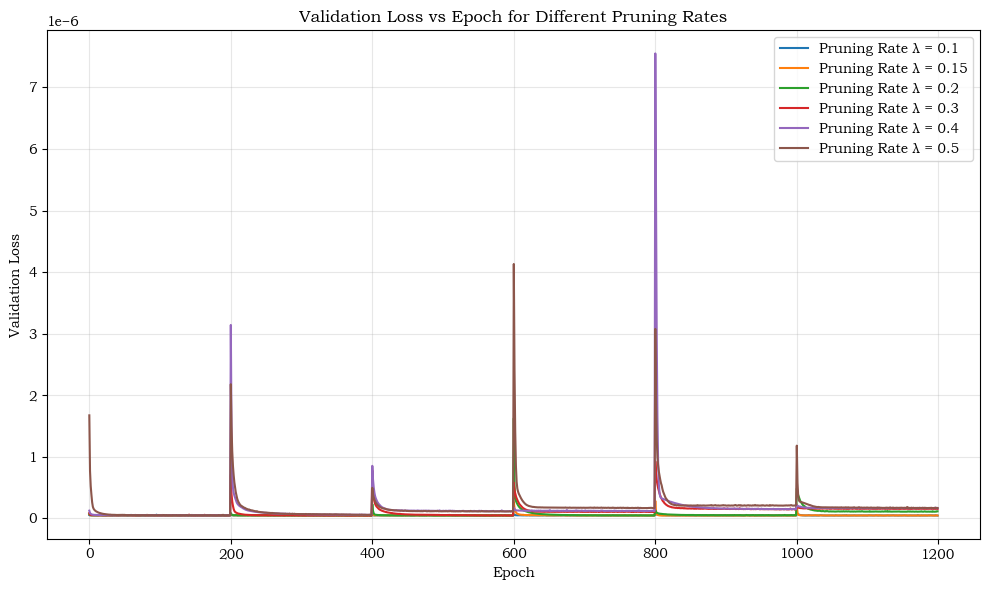

In [20]:
# Plot the losses for different pruning rates
plt.figure(figsize=(10, 6))
for i in range(len(weight_cut_values)):
    result = results[i]
    data_losses = result["data_losses"]
    valid_losses = result["valid_losses"]
    plt.plot(valid_losses, label=f"Pruning Rate λ = {weight_cut_values[i]}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch for Different Pruning Rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

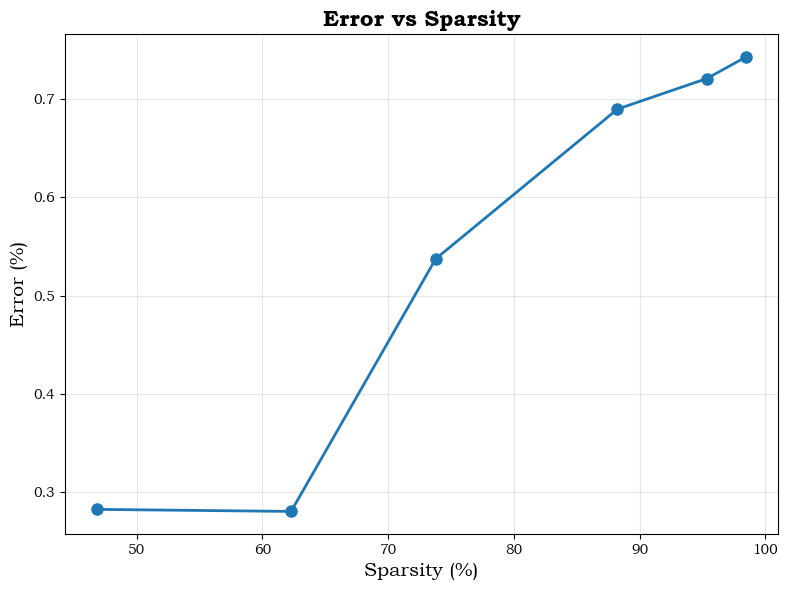

In [21]:
# Plot the errors vs sparsity
sparsity_values = [(1-(1-w)**6)*100 for w in weight_cut_values]
plt.figure(figsize=(8,6))
plt.plot(sparsity_values, [100*err[0] for err in errors], 'o-', linewidth=2, markersize=8)
plt.xlabel("Sparsity (%)", fontsize=14)
plt.ylabel("Error (%)", fontsize=14)
plt.title("Error vs Sparsity", fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()